In [1]:
# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [2]:
# !mkdir -p drive
# !google-drive-ocamlfuse drive

In [3]:
import os 
import sys
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt

from sklearn import model_selection
from __future__ import absolute_import
# os.chdir("/content/drive/Hamming")
# sys.path.append("Hamming")

/home/anton/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
# !pip install hyperopt
# !pip install networkx==1.11

In [5]:
TRAIN_PATH = './dataset_files/hamming_small.txt'  # "/content/drive/Hamming/dataset_files/hamming.txt"

COLUMN_NAMES = ['plainword', 'codeword', 
                'id_error', 'bin_error', 'defective_codeword']
def load_data():
    return pd.read_csv(TRAIN_PATH, sep=';', names=COLUMN_NAMES)

In [6]:
def make_features():
#     data['dec_defective_codeword'] = data['defective_codeword'][:].apply(lambda x: int(x, 2))

    for j in range(len(data['codeword'][0])):
        data['cod_' + str(j)] = data['codeword'][:].apply(lambda x: int(x[j]))

    for j in range(len(data['defective_codeword'][0])):
        data['def_' + str(j)] = data['defective_codeword'][:].apply(lambda x: int(x[j]))

#     for j in range(len(data['bin_error'][0])):
#         data['mask_' + str(j)] = data['bin_error'][:].apply(lambda x: int(x[j]))
        
    data['weight'] = 1
    data.loc[data['codeword'] == data['defective_codeword'], 'weight'] = 19
    for j in range(len(data['plainword'][0])):
        data['pln_' + str(j)] = data['plainword'][:].apply(lambda x: int(x[j]))
    
#     return data

In [7]:
def split_data(test_size): 
    train_data, test_data, train_labels, test_labels = \
        model_selection.train_test_split(data.loc[:, 'def_0':'weight'], 
                                         data.loc[:, 'cod_0':'cod_30'], # 'mask_0':'pln_25' 
                                         test_size = test_size) 
    
    train_weight = train_data.pop('weight')
    test_data.drop(columns=['weight'], inplace=True)
    return np.array(train_data), np.array(test_data), np.array(train_labels), np.array(test_labels), np.array(train_weight)

In [8]:
%%time
data = load_data()
print(data.shape)
make_features()
print(data.shape)

(65536, 5)
(65536, 94)
CPU times: user 2.56 s, sys: 85.7 ms, total: 2.65 s
Wall time: 2.66 s


In [9]:
train_data, test_data, train_labels, test_labels, train_weight = split_data(test_size=0.3)

In [10]:
def probs_to_labels(predicted_probs):
    return [1 if x > 0.5 else 0 for x in predicted_probs]
def count_errors(y, y_pred):
  count = 0
  for i in range (0,31):
    labelBit = y[i]
    resultBit = y_pred[i]
    if labelBit != resultBit:
      count += 1
  return count

In [11]:
# errorStats = {'0': 0}
# for i in range(0, y_pred.shape[0]):
#   resultArray = probs_to_labels(y_pred[i])
#   errorNum = count_errors(test_labels[i], resultArray)
#   if errorStats.get(str(errorNum)) == None:
#     errorStats[str(errorNum)] = 0
#   errorStats[str(errorNum)] += 1
# print(errorStats)

In [12]:
def binary_accuracy(y, y_pred):
    return sum(int(np.array_equal(a, probs_to_labels(b))) for (a,b) in zip(y, y_pred)) / y.shape[0]

In [13]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import roc_auc_score
import sys

In [14]:
X = train_data
y = train_labels
X_val = test_data
y_val = test_labels

In [15]:
scores = []
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adadelta, Adam, rmsprop
import json


In [16]:
from keras.callbacks import History 
history = History()

In [43]:
early_stopping = keras.callbacks.EarlyStopping(monitor='loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

In [44]:
scores_file = 'scores_test.json'

In [45]:
X.shape

(45875, 31)

In [46]:
from random import choice

In [67]:
def make_space():
    activations = ['relu', 'tanh', 'softmax', 'elu']
    units = [128, 256, 512, 1024]
    
    space = {'layers': choice([7 ]), #3, 4, 5, 6, 7]),  # not hp.choice!
         
         'units1': hp.choice('units1', units),
         'units2': hp.choice('units2', units),

         'activation1': hp.choice('activation1', activations),
         'activation2': hp.choice('activation2', activations),

         'batch_size' : hp.choice('batch_size', [32, 64, 128]),

         'nb_epochs' :  hp.choice('nb_epochs', [25 ]), #, 7, 10]),
         'optimizer': hp.choice('optimizer', ['adadelta','adam','rmsprop']),
        #'activation': hp.choice('activation', ['sigmoid', 'tanh']),
         'last_activation': 'sigmoid' #hp.choice('last_activation', ['sigmoid', 'hard_sigmoid'])
    }
    for layer_idx in range(3, space['layers']):
        u = 'units' + str(layer_idx)
        a = 'activation' + str(layer_idx)
        space[u] = hp.choice(u, units)
        space[a] = hp.choice(a, activations)  
        
    return space

In [68]:
space = make_space()

In [69]:
import keras.backend as K 

In [70]:
def binary_metrics(y_true, y_pred):
    print('-'*20)
    print(type(y_true))
    print(y_true)
    print(K.shape(y_true))
    print('-'*20)

    return K.sum(K.equal(y_true, K.round(y_pred)), axis=-1)

In [71]:
def binary_metrics(y_true, y_pred): 
    print('-'*20)
    print(type(y_true))
    print(y_true)
    print(K.shape(y_true))
    print('-'*20)
    
    
    y_true = K.eval(y_true)
    y_pred = K.eval(y_pred)
    
    def probs_to_labels(predicted_probs):
        return [int(x > 0.5) for x in predicted_probs]
    ptl = np.vectorize(probs_to_labels)
    
    y_pred = plt(y_pred)
    
    metric = K.sum(int(np.array_equal(a, b)) for (a, b) in zip(y_true, y_pred)) / y_true.shape[0]
    return K.constant(metric)

In [72]:
def create_model(params):
    model = Sequential()
    model.add(Dense(units=int(params['units1']), input_dim = X.shape[1])) 
    model.add(Activation(params['activation1']))
#     model.add(Dropout(params['dropout1']))
    for layer_idx in range(2, params['layers']):
        u = 'units' + str(layer_idx)
        a = 'activation' + str(layer_idx)

        model.add(Dense(units=params[u], kernel_initializer = "glorot_uniform"))
        model.add(Activation(params[a]))
       
    model.add(Dense(31))
    model.add(Activation(params['last_activation']))
#     from keras.utils import plot_model
#     plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

    model.compile(loss='binary_crossentropy', 
                  metrics=['binary_accuracy'], 
#                   weighted_metrics=[binary_metrics], 
                  optimizer=params['optimizer'])

    return model

In [73]:
def train_and_evaluate__model(model, params):
    model.fit(X, y, 
              epochs=params['nb_epochs'],
              batch_size=int(params['batch_size']),
              sample_weight = train_weight,
              callbacks=[history,
                         early_stopping,
                        ],
              verbose = 0)

    pred_auc = model.predict(X_val)
    return pred_auc

In [74]:
def f_nn(params):   
    print ('Params testing: ', params)
    
    model = create_model(params)
       
    pred_auc = train_and_evaluate__model(model, params)
        
    #     acc = roc_auc_score(y_val, pred_auc)
    acc = binary_accuracy(y_val, pred_auc)
    print('ACCURACY:', acc)
    testing_params = params
    testing_params['accuracy'] = acc
    jsonResult = testing_params
    file = open(scores_file, 'a')
    json.dump(testing_params, file, indent = 4)
    file.write(',\n')
    file.close()
    sys.stdout.flush() 
    scores.append((acc, params))
    return {'loss': -acc, 'status': STATUS_OK}

In [75]:
trials = Trials()
file = open(scores_file, 'w')
file.write('[\n')
file.close()
best = fmin(f_nn, space, algo=tpe.suggest, max_evals=1, trials=trials) ## replace max_evals back to 350
print('best: ')
print(best)
file = open(scores_file, 'a')
file.write(']\n')
file.close()

Params testing:  {'activation1': 'tanh', 'activation2': 'relu', 'activation3': 'relu', 'activation4': 'tanh', 'activation5': 'elu', 'activation6': 'elu', 'batch_size': 32, 'last_activation': 'sigmoid', 'layers': 7, 'nb_epochs': 25, 'optimizer': 'adadelta', 'units1': 128, 'units2': 256, 'units3': 1024, 'units4': 256, 'units5': 256, 'units6': 1024}
ACCURACY: 0.6034789685163522
best: 
{'activation1': 1, 'activation2': 0, 'activation3': 0, 'activation4': 1, 'activation5': 3, 'activation6': 3, 'batch_size': 0, 'nb_epochs': 0, 'optimizer': 0, 'units1': 0, 'units2': 1, 'units3': 3, 'units4': 1, 'units5': 1, 'units6': 3}


In [76]:
history.history

{'loss': [0.2565906487989166,
  0.15275710067209822,
  0.1359304219604513,
  0.1213886003203548,
  0.10737223278988935,
  0.09201393942563345,
  0.07644654992409558,
  0.060896951187533965,
  0.046010836530121536,
  0.032866708943686304,
  0.021953414339054508,
  0.013223913908431088,
  0.00716795656219003,
  0.0033521330775490047,
  0.0013369084098224075,
  0.0005932079397233289,
  0.0003764526954742925,
  0.0002911074603565179,
  0.00024054130048260132,
  0.0002046234405720708,
  0.00017819829067032612,
  0.00015734422021280284,
  0.00014071336924066711,
  0.000126954396416456,
  0.00011553185428771868],
 'binary_accuracy': [0.941020639192181,
  0.9679795903470926,
  0.9686694069545341,
  0.9694337608184087,
  0.9705982213605002,
  0.972662042517753,
  0.9752989478669959,
  0.9789111528968292,
  0.983123859823887,
  0.987390712567831,
  0.991588651119201,
  0.9950313832506497,
  0.9975599938686277,
  0.999168156553679,
  0.9998952300360158,
  0.9999971873935627,
  1.0,
  1.0,
  1.0,


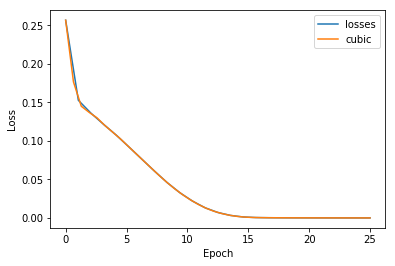

In [77]:
from scipy.interpolate import interp1d

losses = history.history['loss']
epochs = np.linspace(0, len(losses), num=len(losses), endpoint=True)

xnew = np.linspace(0, len(losses), num=40, endpoint=True)
f = interp1d(epochs, losses, kind='cubic')

plt.plot(epochs, losses, '-', xnew, f(xnew))
plt.legend(['losses', 'cubic'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [79]:
print(max(scores))

(0.6034789685163522, {'activation1': 'tanh', 'activation2': 'relu', 'activation3': 'relu', 'activation4': 'tanh', 'activation5': 'elu', 'activation6': 'elu', 'batch_size': 32, 'last_activation': 'sigmoid', 'layers': 7, 'nb_epochs': 25, 'optimizer': 'adadelta', 'units1': 128, 'units2': 256, 'units3': 1024, 'units4': 256, 'units5': 256, 'units6': 1024, 'accuracy': 0.6034789685163522})


# Cross validate

In [80]:
from sklearn.model_selection import StratifiedKFold

In [81]:
!ls

best_model.hd5	     hyperopt_codes_2.ipynb  scores.json
best_params.json     hyperopt_codes.ipynb    scores_test.json
dataset_files	     model_lib.py	     visualisation.ipynb
functions.py	     README.md
hamming-codes.ipynb  score_analyzer.py


In [82]:
import json

In [83]:
with open('best_params.json', 'r') as file:
    best_params = json.load(file)
best_params

{'activation1': 'elu',
 'activation2': 'relu',
 'activation3': 'relu',
 'batch_size': 64,
 'dropout1': 1,
 'dropout2': 1,
 'dropout3': 1,
 'last_activation': 'sigmoid',
 'nb_epochs': 10,
 'optimizer': 'adam',
 'units1': 1024,
 'units2': 1024,
 'units3': 1024,
 'accuracy': 0.7830403645833334,
 'activation4': 'tanh',
 'dropout4': 1,
 'layers': 4,
 'units4': 128}

In [84]:
def check_cv(n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for i in range(n_splits):
        train, test = skf.split(train_data, train_labels)
        print("Running Fold", i+1, "/", n_folds)
        model = None # Clearing the NN.
        model = create_model(best_params)
        pred_auc = train_and_evaluate__model(model, best_params)
        acc = binary_accuracy(y_val, pred_auc)
        print('ACCURACY:', acc)

In [85]:
check_cv()

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'multilabel-indicator' instead.